This tutorial trains a <a href="https://arxiv.org/abs/1706.03762" class="external">Transformer model</a> to translate a [Portuguese to English dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en). This is an advanced example that assumes knowledge of [text generation](https://www.tensorflow.org/text/tutorials/text_generation) and [attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

The core idea behind the Transformer model is *self-attention*—the ability to attend to different positions of the input sequence to compute a representation of that sequence. Transformer creates stacks of self-attention layers and is explained below in the sections *Scaled dot product attention* and *Multi-head attention*.

A transformer model handles variable-sized input using stacks of self-attention layers instead of [RNNs](https://www.tensorflow.org/text/tutorials/text_classification_rnn) or [CNNs](https://www.tensorflow.org/tutorials/images/cnn). This general architecture has a number of advantages:

* It makes no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8)).
* Layer outputs can be calculated in parallel, instead of a series like an RNN.
* Distant items can affect each other's output without passing through many RNN-steps, or convolution layers (see [Scene Memory Transformer](https://arxiv.org/pdf/1903.03878.pdf) for example).
* It can learn long-range dependencies. This is a challenge in many sequence tasks.

The downsides of this architecture are:

* For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.   
* If the input *does* have a  temporal/spatial relationship, like text, some positional encoding must be added or the model will effectively see a bag of words. 

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

## Setup

In [177]:
from collections import Counter
import logging
import os
import pathlib
import re
import string
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from PIL import Image
from nltk.corpus import stopwords

In [2]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

## Load the Dataset

Use [TensorFlow datasets](https://www.tensorflow.org/datasets) to load the [Portuguese-English translation dataset](https://github.com/neulab/word-embeddings-for-nmt) from the [TED Talks Open Translation Project](https://www.ted.com/participate/translate).



In [107]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples, test_examples = examples['train'], examples['validation'], examples["test"]

## Exploratory Data Analysis

View some samples:

In [12]:
for pt_examples, en_examples in train_examples.batch(4).take(1):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .
e esta rebeldia consciente é a razão pela qual eu , como agnóstica , posso ainda ter fé .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .
and this conscious defiance is why i , as an agnostic , can still have faith .


We have to convert the prefetched dataset to a standard tensorflow dataset. We then convert it to a pandas dataframe with one column, containing an array of bytes for the english and Portuguese texts. We convert decode this byte array and split it into 2 columns and save the results to perform EDA on it.

In [102]:
def ds_to_df(prefetch_ds):
    ds = tf.data.Dataset.from_tensor_slices(list(prefetch_ds))
    df = tfds.as_dataframe(ds)
    eng = []
    pt = []
    for index, row in df.iterrows():
        pt.append(row[0][0].decode("utf-8"))
        eng.append(row[0][1].decode("utf-8"))
    df["English"] = eng
    df["Portuguese"] = pt
    return df


In [108]:
train_df = ds_to_df(train_examples)
test_df = ds_to_df(test_examples)
val_df = ds_to_df(val_examples)

train_df.to_csv("Input/train.csv")
train_df.to_csv("Input/test.csv")
train_df.to_csv("Input/val.csv")

Merge to one dataframe

In [110]:
data = train_df.append(test_df)
data = data.append(val_df)


In [122]:
data.to_csv("Input/data.csv")

We see that most of the data is assigned to Training, with around 1000 samples for test and validation.

In [121]:
print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")

Train: 51785
Validation: 1193
Test: 1803


In [123]:
#no empty cells
data.isnull().sum()

              0
English       0
Portuguese    0
dtype: int64

We can count the number of words in each of the strings. Certain punctuation will be included in the count due to the fact that they are registered as tokens in the actual translator model.

In [130]:
data["eng_len"] = data["English"].str.split().str.len()
data["pt_len"] = data["Portuguese"].str.split().str.len()


In [135]:
data

,,English,Portuguese,eng_len,pt_len
0,"[b'e quando melhoramos a procura , tiramos a \...","and when you improve searchability , you actua...","e quando melhoramos a procura , tiramos a únic...",20,18
1,"[b'mas e se estes fatores fossem ativos ?', b'...",but what if it were active ?,mas e se estes fatores fossem ativos ?,7,8
2,[b'mas eles n\xc3\xa3o tinham a curiosidade de...,but they did n't test for curiosity .,mas eles não tinham a curiosidade de me testar .,8,10
3,[b'e esta rebeldia consciente \xc3\xa9 a raz\x...,"and this conscious defiance is why i , as an a...",e esta rebeldia consciente é a razão pela qual...,17,19
4,"[b""`` `` '' podem usar tudo sobre a mesa no me...",you can use everything on the table on me .,`` `` '' podem usar tudo sobre a mesa no meu c...,10,14
...,...,...,...,...,...
1188,"[b'uma , com pele amendoim torrado , e outra ,...","one in a toasted-peanut skin and the other , a...","uma , com pele amendoim torrado , e outra , ta...",22,23
1189,"[b""`` na alemanha , por exemplo , h\xc3\xa1 ap...","for example , in germany , just a couple of we...","`` na alemanha , por exemplo , há apenas umas ...",34,41
1190,"[b'na verdade , pelo contr\xc3\xa1rio , real\x...","in fact , on the contrary , it highlights them .","na verdade , pelo contrário , realça-as .",11,8
1191,[b'alice era muito amistosa e soci\xc3\xa1vel ...,"so , alice was very outgoing and sociable , an...",alice era muito amistosa e sociável e george e...,15,12


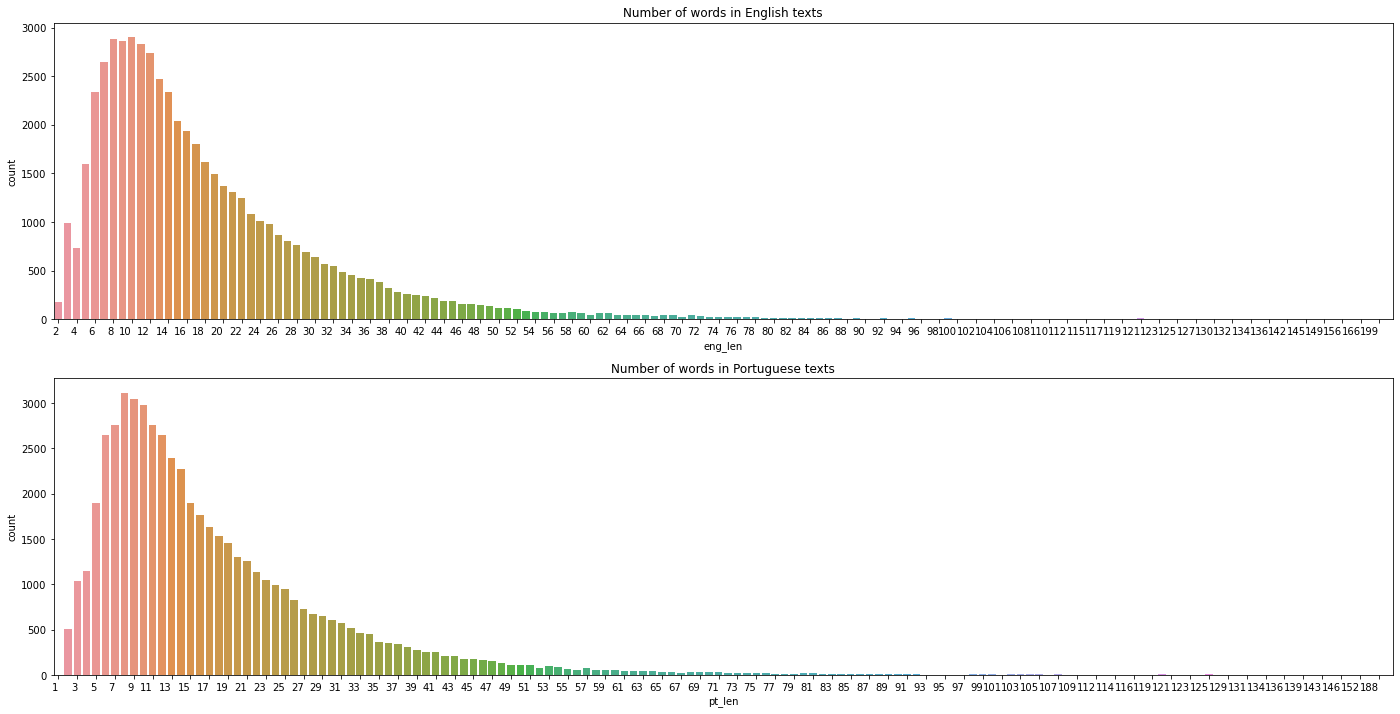

In [134]:
from matplotlib import ticker

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(24,12))
sns.countplot(data=data, x="eng_len",ax = ax[0])
plt.setp(ax[0].get_xticklabels(), ha="right", rotation_mode="anchor")
sns.countplot(data=data, x="pt_len", ax = ax[1])
plt.setp(ax[1].get_xticklabels(), ha="right", rotation_mode="anchor")

ax[0].set_title("Number of words in English texts")
ax[1].set_title("Number of words in Portuguese texts")

ax[0].xaxis.set_major_locator(ticker.MultipleLocator(base=2))
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(base=2))

The distribution fo the length of texts are more or less the same in English and Portuguese, where we have the majority of the data having lengths of around 10-12 words. This will generally be one to two sentences. We can see that the these graphs are similar to a chi-square distribution.

<img src="https://statkat.com/images/chi-squared-distribution.png" width="500" alt="scaled_dot_product_attention">

In [163]:
def counter_plots(texts, titles, top=15):
    num = len(texts)
    fig, ax = plt.subplots(nrows=1, ncols=num, figsize=(21,5))

    for i in range(num):
        sns.barplot(
            x = pd.DataFrame.from_dict(dict(Counter(' '.join([text for text in texts[i]]).split()).most_common(top)), orient="index").reset_index()["index"],
            y = pd.DataFrame.from_dict(dict(Counter(' '.join([text for text in texts[i]]).split()).most_common(top)), orient="index").reset_index()[0],
            ax = ax[i]
        )
        ax[i].set_title(titles[i])
        ax[i].set_ylabel("Count")
        plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.show()

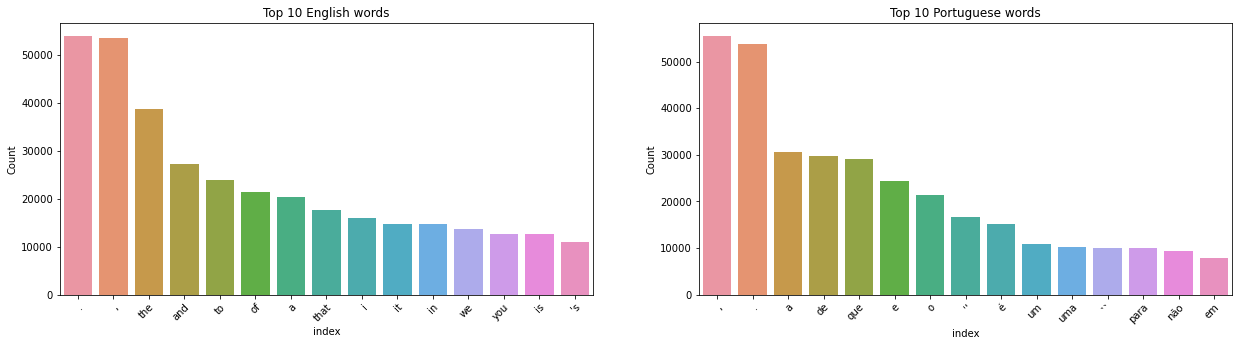

In [164]:
texts = [data["English"], data["Portuguese"]]
titles = ["Top 10 English words",
         "Top 10 Portuguese words"]

counter_plots(texts, titles)

In [181]:
def clean_text(text):

    text = re.sub(r'[^a-zA-Z#]', ' ', text) # removing symbols
    text = " ".join(w for w in text.split() if len(w) > 2) # removing smaller tha 3 letter words

    return text

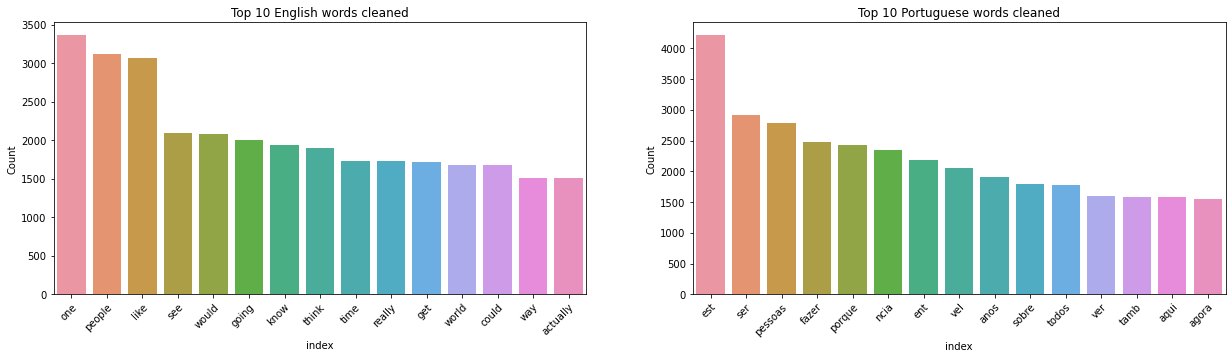

In [183]:
data_clean_eng = []
data_clean_pt = []
stop_words_eng = set(stopwords.words('english'))
stop_words_pt = set(stopwords.words('portuguese'))
for i in data["English"]:
    data_clean_eng.append(" ".join([text for text in clean_text(i).split() if not text in stop_words_eng and not text in string.punctuation ]))
for i in data["Portuguese"]:
    data_clean_pt.append(" ".join([text for text in clean_text(i).split() if not text in stop_words_pt and not text in string.punctuation ]))

texts = [data_clean_eng, data_clean_pt]
titles = ["Top 10 English words cleaned",
         "Top 10 Portuguese words cleaned"]

counter_plots(texts, titles)

In [178]:
def word_clouds_text(texts, titles):
    flags = ["Image/uk.png", "Image/pt.png"]
    num = len(texts)
    fig, ax = plt.subplots(nrows=1, ncols=num, figsize=(21,5))
    plt.tight_layout()

    for i in range(num):
        mask = np.array(Image.open(flags[i]))

        text_wc = WordCloud(random_state=21, background_color="white",mode="RGBA", max_words=1000, mask=mask, stopwords=stop_words_pt.union(stop_words_eng)).generate(texts[i])

        image_colors = ImageColorGenerator(mask)
        ax[i].imshow(text_wc.recolor(color_func=image_colors), interpolation="bilinear")
        #ax[i].imshow(text_wc, interpolation="bilinear")
        ax[i].axis('off')
        ax[i].set_title(titles[i])

    plt.show()

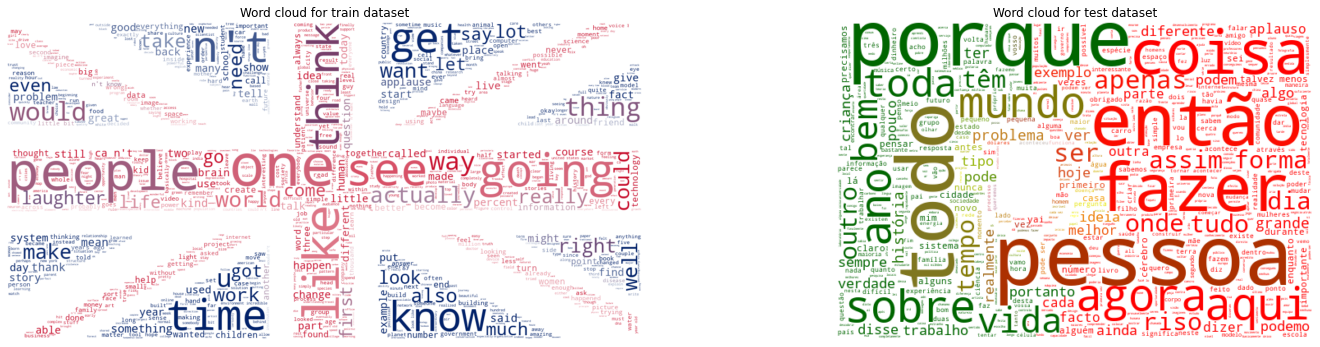

In [179]:
english_words = ' '.join([text for text in data["English"]])
portuguese_words  = ' '.join([text for text in data["Portuguese"]])


texts = [english_words, portuguese_words]
titles = ["Word cloud for English text",
          "Word cloud for Portuguese text "]

word_clouds_text(texts, titles)

## Text tokenization & detokenization

The text needs to be tokenized, to do this, we use a pretrained tokenizer for the dataset.


Essentially the tokenizer generates its dictionary based off of the most popular words, and for less popular words it creates them through small subwords based on the most occurring permutations of the words i.e. if a words is popular it will have its own token, but if it is not popular it will be compromised of various sub tokens.

In [5]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

'.\\ted_hrlr_translate_pt_en_converter.zip'

In [6]:
tokenizers = tf.saved_model.load(model_name)

The tokenizer contains tokenizers for both English and Portuguese.
The tokenizer has the following methods:

In [7]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

Tokenizing converts strings to tokens representing words. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing.

In [8]:
for en in en_examples.numpy():
  print(en.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .
and this conscious defiance is why i , as an agnostic , can still have faith .


In [9]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]
[2, 72, 81, 2508, 2159, 3072, 1282, 80, 192, 45, 13, 100, 111, 6040, 3176, 3186, 13, 94, 235, 89, 1938, 15, 3]


Detokenizing reverses the process.

In [10]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .
and this conscious defiance is why i , as an agnostic , can still have faith .


We can see the lower level structure of the tokens. The data is stored as a RaggedTensor, meaning that each sample has different lengths. Less popular words are split into sub tokens, indicated by the ##

In [11]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability', b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage', b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip', b'##ity', b'.', b'[END]'], [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?', b'[END]'], [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for', b'curiosity', b'.', b'[END]'], [b'[START]', b'and', b'this', b'conscious', b'de', b'##fi', b'##ance', b'is', b'why', b'i', b',', b'as', b'an', b'ag', b'##no', b'##stic', b',', b'can', b'still', b'have', b'faith', b'.', b'[END]']]>

## Model input

We need to tokenize the text and convert it to tensors.

In [14]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

Batch size of 32 was selected, due to VRAM limitations. We then create shuffled batches from this data.

In [15]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32

In [16]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

## Positional encoding

The model we will be using is the attention based Encoder-Decoder Transformer. This model does not use any RNN to keep context of words. Instead, the model uses attention combined with an encoding vector. The encoding vector creates the positional vector responsible for identifying the relative position of a word in the input sequence. Essentially similar tokens in similar positions will be near each other in a p-dimensional space.

The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [17]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [18]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

A visualization of the positional encoding for 2048 samples with a 512 dimensional model.

(1, 2048, 512)


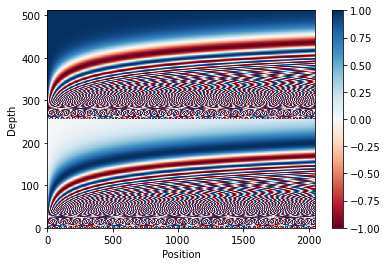

In [96]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Masking

Next we have to mask the padding tokens to ensure they are not treated as inputs. 1 represents a padded location, 0 otherwise.


In [20]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [21]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

We use the look-ahead to indicates which entries should not be used in teh rest of the sequence. The model should only see the previous values in the sequence.


In [22]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [103]:
x = tf.random.uniform((1, 4))
print(x)
temp = create_look_ahead_mask(x.shape[1])
print(temp)

tf.Tensor([[0.5320257  0.49193728 0.80223715 0.0673027 ]], shape=(1, 4), dtype=float32)
tf.Tensor(
[[0. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]], shape=(4, 4), dtype=float32)


## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$

<img src="https://www.researchgate.net/profile/Shen-Leixian/publication/325856086/figure/fig1/AS:723221292789765@1549440801787/Softmax-function-image.png">



The dot-product attention is scaled by a factor of square root of the depth and the mask is multiplied with -1e9 (close to negative infinity). To better normalize the values.

In [108]:
def scaled_dot_product_attention(q, k, v, mask):

  matmul_qk = tf.matmul(q, k, transpose_b=True)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the tokens you want to focus on are kept as-is and the irrelevant tokens are flushed out.

In [109]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [127]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

tf.Tensor([4 3], shape=(2,), dtype=int32)
Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [29]:
#the first query shows a repeated key, ie 50% belonging to value 3 and 50% to value 4
#the second query matches key 2
# the third query is between key 1 and key 2
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers.
*    Scaled dot-product attention.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers before the multi-head attention function.
The attention heads are broadcast to be calculated in parallel.


ENCODER SELF ATTENTION

DECODER USES ATTENTION FROM ENCODER


In [30]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)
    k = self.wk(k)
    v = self.wv(v)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

## Feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.


In [32]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](https://www.tensorflow.org/text/tutorials/nmt_with_attention.ipynb). 

* The input sentence is passed through N encoder layers, generating an output for each token in the sequence.
* The decoder uses the encoder's output and its own input (self-attention) to predict the next word.

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks.

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.


In [34]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next token by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [36]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [38]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [40]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [42]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    inp, tar = inputs

    enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

## Set hyperparameters

To keep this example small and relatively fast, the values for the hyperparameters have been reduced:

The base model described in the [paper](https://arxiv.org/abs/1706.03762) used: `num_layers=6, d_model=512, dff=2048`.

In [44]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$


In [45]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [46]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

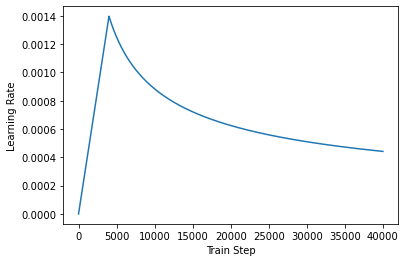

In [47]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [48]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [49]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [50]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training and checkpointing

In [51]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [52]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each token, *self-attention* allows it to look at the previous tokens in the input sequence to better predict the next token.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [53]:
EPOCHS = 20

In [54]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

Portuguese is used as the input language and English is the target language.

In [55]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.8962 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.8304 Accuracy 0.0002
Epoch 1 Batch 100 Loss 8.7331 Accuracy 0.0198
Epoch 1 Batch 150 Loss 8.6243 Accuracy 0.0328
Epoch 1 Batch 200 Loss 8.4919 Accuracy 0.0395
Epoch 1 Batch 250 Loss 8.3311 Accuracy 0.0450
Epoch 1 Batch 300 Loss 8.1506 Accuracy 0.0512
Epoch 1 Batch 350 Loss 7.9574 Accuracy 0.0577
Epoch 1 Batch 400 Loss 7.7713 Accuracy 0.0637
Epoch 1 Batch 450 Loss 7.6009 Accuracy 0.0702
Epoch 1 Batch 500 Loss 7.4540 Accuracy 0.0761
Epoch 1 Batch 550 Loss 7.3228 Accuracy 0.0820
Epoch 1 Batch 600 Loss 7.2044 Accuracy 0.0881
Epoch 1 Batch 650 Loss 7.0940 Accuracy 0.0948
Epoch 1 Batch 700 Loss 6.9904 Accuracy 0.1011
Epoch 1 Batch 750 Loss 6.8927 Accuracy 0.1073
Epoch 1 Batch 800 Loss 6.8047 Accuracy 0.1126
Epoch 1 Batch 850 Loss 6.7224 Accuracy 0.1178
Epoch 1 Batch 900 Loss 6.6457 Accuracy 0.1225
Epoch 1 Batch 950 Loss 6.5739 Accuracy 0.1269
Epoch 1 Batch 1000 Loss 6.5042 Accuracy 0.1314
Epoch 1 Batch 1050 Loss 6.4398 Accur

### Run inference

The following steps are used for inference:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

In [56]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=20):
    # input sentence is portuguese, hence adding the start and end token
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
    
    encoder_input = sentence

    # as the target is english, the first token to the transformer should be the
    # english start token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)
    
    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)
      
      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # output.shape (1, tokens)
    text = tokenizers.en.detokenize(output)[0]  # shape: ()

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop. So recalculate them outside
    # the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

Create an instance of this `Translator` class, and try it out a few times:

In [57]:
translator = Translator(tokenizers, transformer)

In [58]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [59]:
sentence = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


In [60]:
sentence = "os meus vizinhos ouviram sobre esta ideia."
ground_truth = "and my neighboring homes heard about this idea ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


In [61]:
sentence = "vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."
ground_truth = "so i \'ll just share with you some stories very quickly of some magical things that have happened ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to very quickly share with you some magical stories of some magical things that happened
Ground truth   : so i 'll just share with you some stories very quickly of some magical things that have happened .


## Attention plots

The `Translator` class returns a dictionary of attention maps you can use to visualize the internal working of the model:

In [62]:
sentence = "este é o primeiro livro que eu fiz."
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


In [63]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [64]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

In [65]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

In [66]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

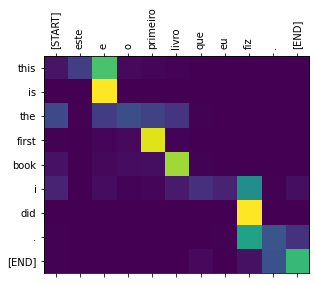

In [67]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [68]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

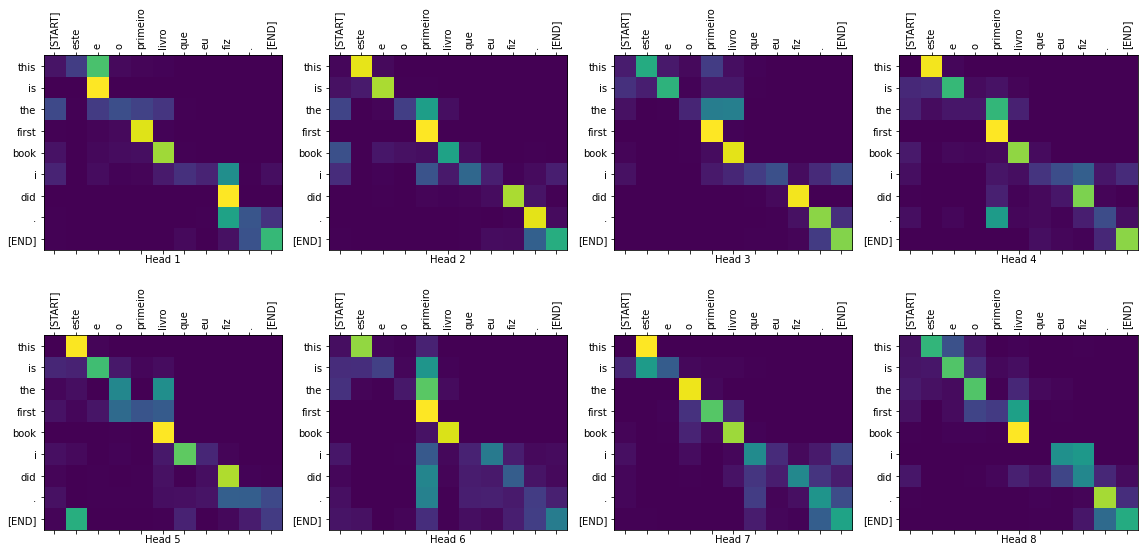

In [69]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

The model does okay on unfamiliar words. Neither "triceratops" or "encyclopedia" are in the input dataset and the model almost learns to transliterate them, even without a shared vocabulary:

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about triopcom in the enclory .
Ground truth   : I read about triceratops in the encyclopedia.


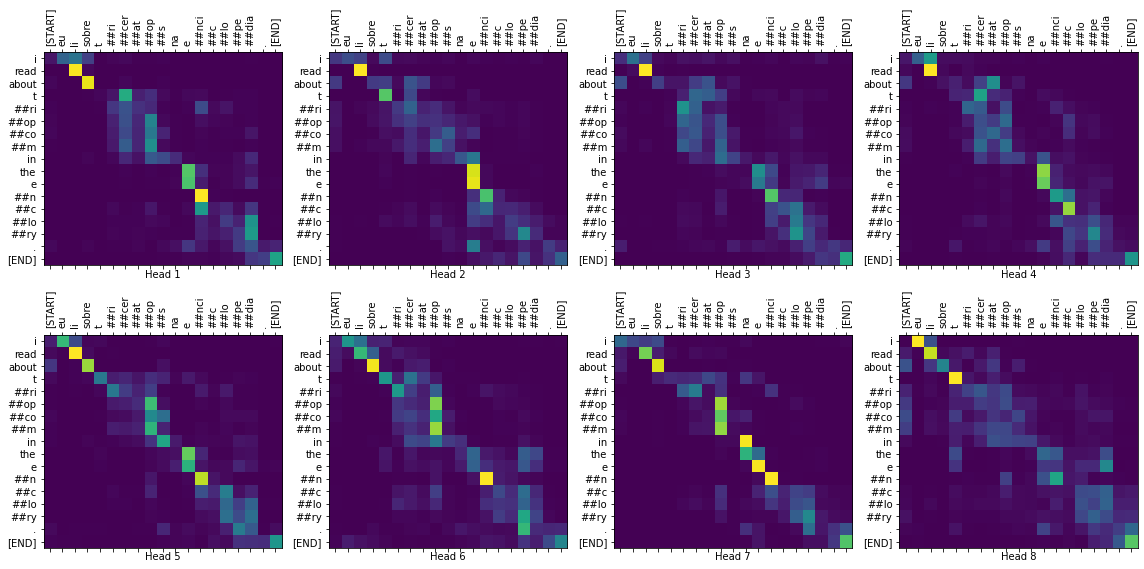

In [70]:
sentence = "Eu li sobre triceratops na enciclopédia."
ground_truth = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

## Export

That inference model is working, so next you'll export it as a `tf.saved_model`.

To do that, wrap it in yet another `tf.Module` sub-class, this time with a `tf.function` on the `__call__` method:

In [71]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result, 
     tokens,
     attention_weights) = self.translator(sentence, max_length=100)
    
    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

In [72]:
translator = ExportTranslator(translator)

Since the model is decoding the predictions using `tf.argmax` the predictions are deterministic. The original model and one reloaded from its `SavedModel` should give identical predictions:

In [73]:
translator("este é o primeiro livro que eu fiz.").numpy()

b'this is the first book i did .'

In [74]:
tf.saved_model.save(translator, export_dir='translator')

In [75]:
reloaded = tf.saved_model.load('translator')

In [76]:
reloaded("este é o primeiro livro que eu fiz.").numpy()

b'this is the first book i did .'

## Summary

In this tutorial, you learned about positional encoding, multi-head attention, the importance of masking and how to create a transformer.

Try using a different dataset to train the transformer. You can also create the base transformer or transformer XL by changing the hyperparameters above. You can also use the layers defined here to create [BERT](https://arxiv.org/abs/1810.04805) and train state of the art models. Furthermore, you can implement beam search to get better predictions.